In [1]:
library(Seurat)
library(SeuratDisk)
library(Signac)
library(EnsDb.Hsapiens.v86)
library(dplyr)
library(ggplot2)
library(stringr)
library(patchwork)
library(CelliD)
library(tidyverse) # general purpose library for data handling
library(ggpubr)

Warning message in fun(libname, pkgname):
“rgeos: versions of GEOS runtime 3.11.0-CAPI-1.17.0
and GEOS at installation 3.10.2-CAPI-1.16.0differ”
Attaching SeuratObject

Attaching sp

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Loading required package: ensembldb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required pack

In [2]:
# My parameters
h5_name = "/home/vsevim/prj/tf/CATATAC_4/analysis/secondary/TF2CRISPR2/seurat/CATATAC_4_TF2CRISPR2_ONLY_SINGLETS.h5seurat"
h5_w_gcap_name <- sub(".h5seurat", "_w_GUIDE_CAP.h5seurat", h5_name)

protosp_path = "/home/vsevim/prj/tf/CATATAC_4/analysis/primary/TF2CRISPR2/resources/protospacers_TF2.csv"
cellid_output_path = "/home/vsevim/prj/tf/CATATAC_4/analysis/primary/TF2CRISPR2/cell_ID/"
library = "TF2CRISPR2"
tsv_path = "/home/vsevim/prj/tf/CATATAC_4/analysis/primary/TF2CRISPR2/tsv"

# Define CellID func

In [3]:
get_cell_ids <- function(seurat_obj, cluster_id, max_minuslog10_q_val = 4, output_dir){
    if (cluster_id == "ALL_CELLS"){
        subset_seurat <- seurat_obj
    }
    else {
        subset_seurat  <- subset(x = seurat_obj, celltype == cluster_id)
    }
    HGT_all_gs <- RunCellHGT(subset_seurat, pathways = all_gs, dims = 1:50)
    
    all_gs_prediction <- rownames(HGT_all_gs)[apply(HGT_all_gs, 2, which.max)]
    all_gs_prediction_signif <- ifelse(
        apply(HGT_all_gs, 2, max) > max_minuslog10_q_val, 
        yes = all_gs_prediction, 
        "unassigned"
    )
    cell_count <- length(all_gs_prediction)
    plot_title <- paste("Cluster", cluster_id, ",", cell_count, "cells", ", q < 10^-", max_minuslog10_q_val)
    file_name  <- paste0("Cluster_", cluster_id, "__q_1e-", max_minuslog10_q_val,".png")
    options(repr.plot.width=12, repr.plot.height=10)
    par(las=3)
    par(mar=c(17,5,1,1))

    select_assigned          = all_gs_prediction_signif != 'unassigned'
    all_gs_prediction_signif = all_gs_prediction_signif[select_assigned]

    pred_table <- sort(table(all_gs_prediction_signif))
    #pred_table <- t(as.matrix(as.data.frame(pred_table)))
    barplot(pred_table, 
         main=plot_title,
         xlab = "",
         ylab = "#cells",
         cex.axis = 1.5,
         cex.lab = 1.5,
         cex.names = 1.5,
         cex.main = 1.5
    )

     
    cur_dir <- getwd()
    setwd(output_dir)
    png(file_name, width=600, height=350)
    par(las=3)
    par(mar=c(13,5,1,1))
    barplot(pred_table, main=plot_title)
    dev.off()
    setwd(cur_dir)
    pred_table
}

# Load protospacer file

In [4]:
df_protosp = read.table(protosp_path, header=TRUE, comment.char="")

In [5]:
tfs_w_ntctl    = unique(df_protosp$X.TargetGene)
unselect_ntctl = (tfs_w_ntctl != "NTCTL") & (tfs_w_ntctl != "NTCTRL")
tfs_to_plot    = tfs_w_ntctl[unselect_ntctl]

guides_to_plot  = df_protosp$GuideName
tfs_to_plot
guides_to_plot

[1] "OTP"   "MYF6"  "MEIS1" "FLI1"  "HHEX"  "HOXA6" "ELF5"  "GBX1"  "DPRX"

[1] "OTP_1"   "OTP_2"   "MYF6_1"  "MYF6_2"  "MEIS1_1" "MEIS1_2" "FLI1_1" 
 [8] "FLI1_2"  "HHEX_1"  "HHEX_2"  "HOXA6_1" "HOXA6_2" "ELF5_1"  "ELF5_2" 
[15] "GBX1_1"  "GBX1_2"  "DPRX_1"  "DPRX_2"  "NTCTL_1" "NTCTL_2"

# Load Seurat object

In [6]:
if (!exists("seurat")) {
    seurat <- LoadH5Seurat(h5_w_gcap_name)
}

Validating h5Seurat file

Initializing ATAC with data

Adding counts for ATAC

Adding feature-level metadata for ATAC

Adding variable feature information for ATAC

Adding miscellaneous information for ATAC

Initializing RNA with data

Adding counts for RNA

Adding miscellaneous information for RNA

Initializing SCT with data

Adding counts for SCT

Adding scale.data for SCT

Adding variable feature information for SCT

Adding miscellaneous information for SCT

Initializing guidecapture with data

Adding counts for guidecapture

Adding miscellaneous information for guidecapture

Adding reduction lsi

Adding cell embeddings for lsi

Adding feature loadings for lsi

Adding miscellaneous information for lsi

Adding reduction umap.atac

Adding cell embeddings for umap.atac

Adding miscellaneous information for umap.atac

Adding reduction wnn.umap

Adding cell embeddings for wnn.umap

Adding miscellaneous information for wnn.umap

Adding reduction pca

Adding cell embeddings for pca

Adding

In [7]:
seurat_negatives <- subset(seurat, idents = "Negative")
seurat_singlets  <- subset(seurat, idents = "Singlet")
seurat_doublets  <- subset(seurat, idents = "Doublet")

Idents(seurat_singlets) <- seurat_singlets@meta.data$guidecapture_classification
Idents(seurat_doublets) <- seurat_doublets@meta.data$guidecapture_classification

In [8]:
seurat <- SetIdent(seurat, value = seurat@meta.data$seurat_clusters)

In [9]:
seurat <- RenameIdents(seurat, '5' = 'iPSC')
seurat <- RenameIdents(seurat, '8' = 'MEIS1')
seurat <- RenameIdents(seurat, '17' = 'ELF5')
seurat <- RenameIdents(seurat, '13' = 'OTP')
seurat <- RenameIdents(seurat, '12' = 'MYF6')

In [10]:
seurat$celltype <- Idents(seurat)

# Visualize

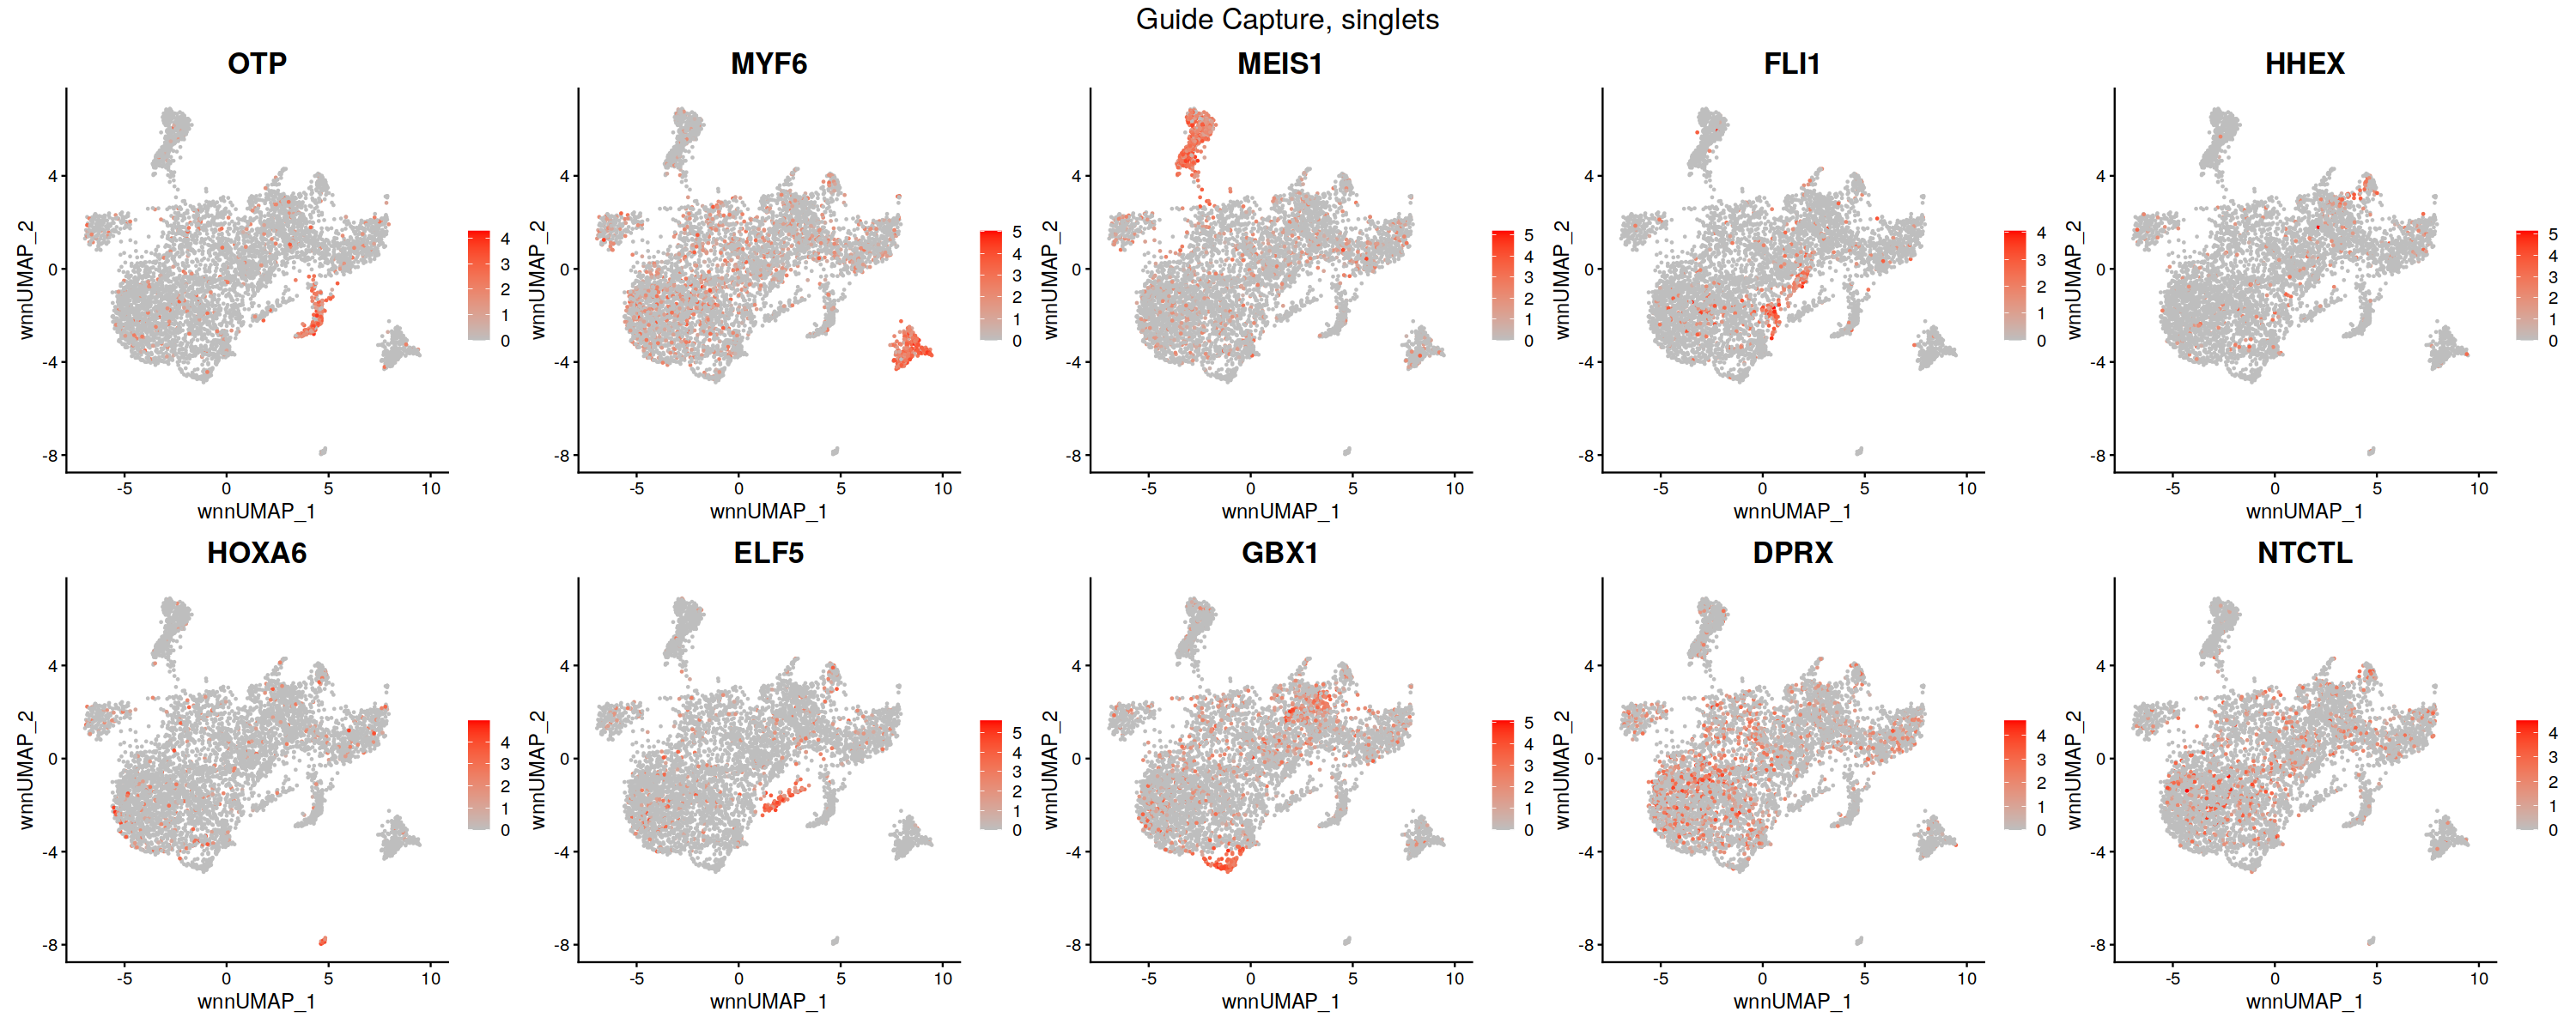

In [11]:
options(repr.plot.width = 25, repr.plot.height = 10)
guide_list <- tfs_w_ntctl
DefaultAssay(seurat) <- "guidecapture"
FeaturePlot(
    seurat,
    features = guide_list,
    reduction = 'wnn.umap',
    cols = c("grey", "red"),
    keep.scale = "feature",
    ncol = length(guide_list)/2
) +
plot_annotation(title = "Guide Capture, singlets") &
theme(plot.title = element_text(hjust = 0.5, size = 20))

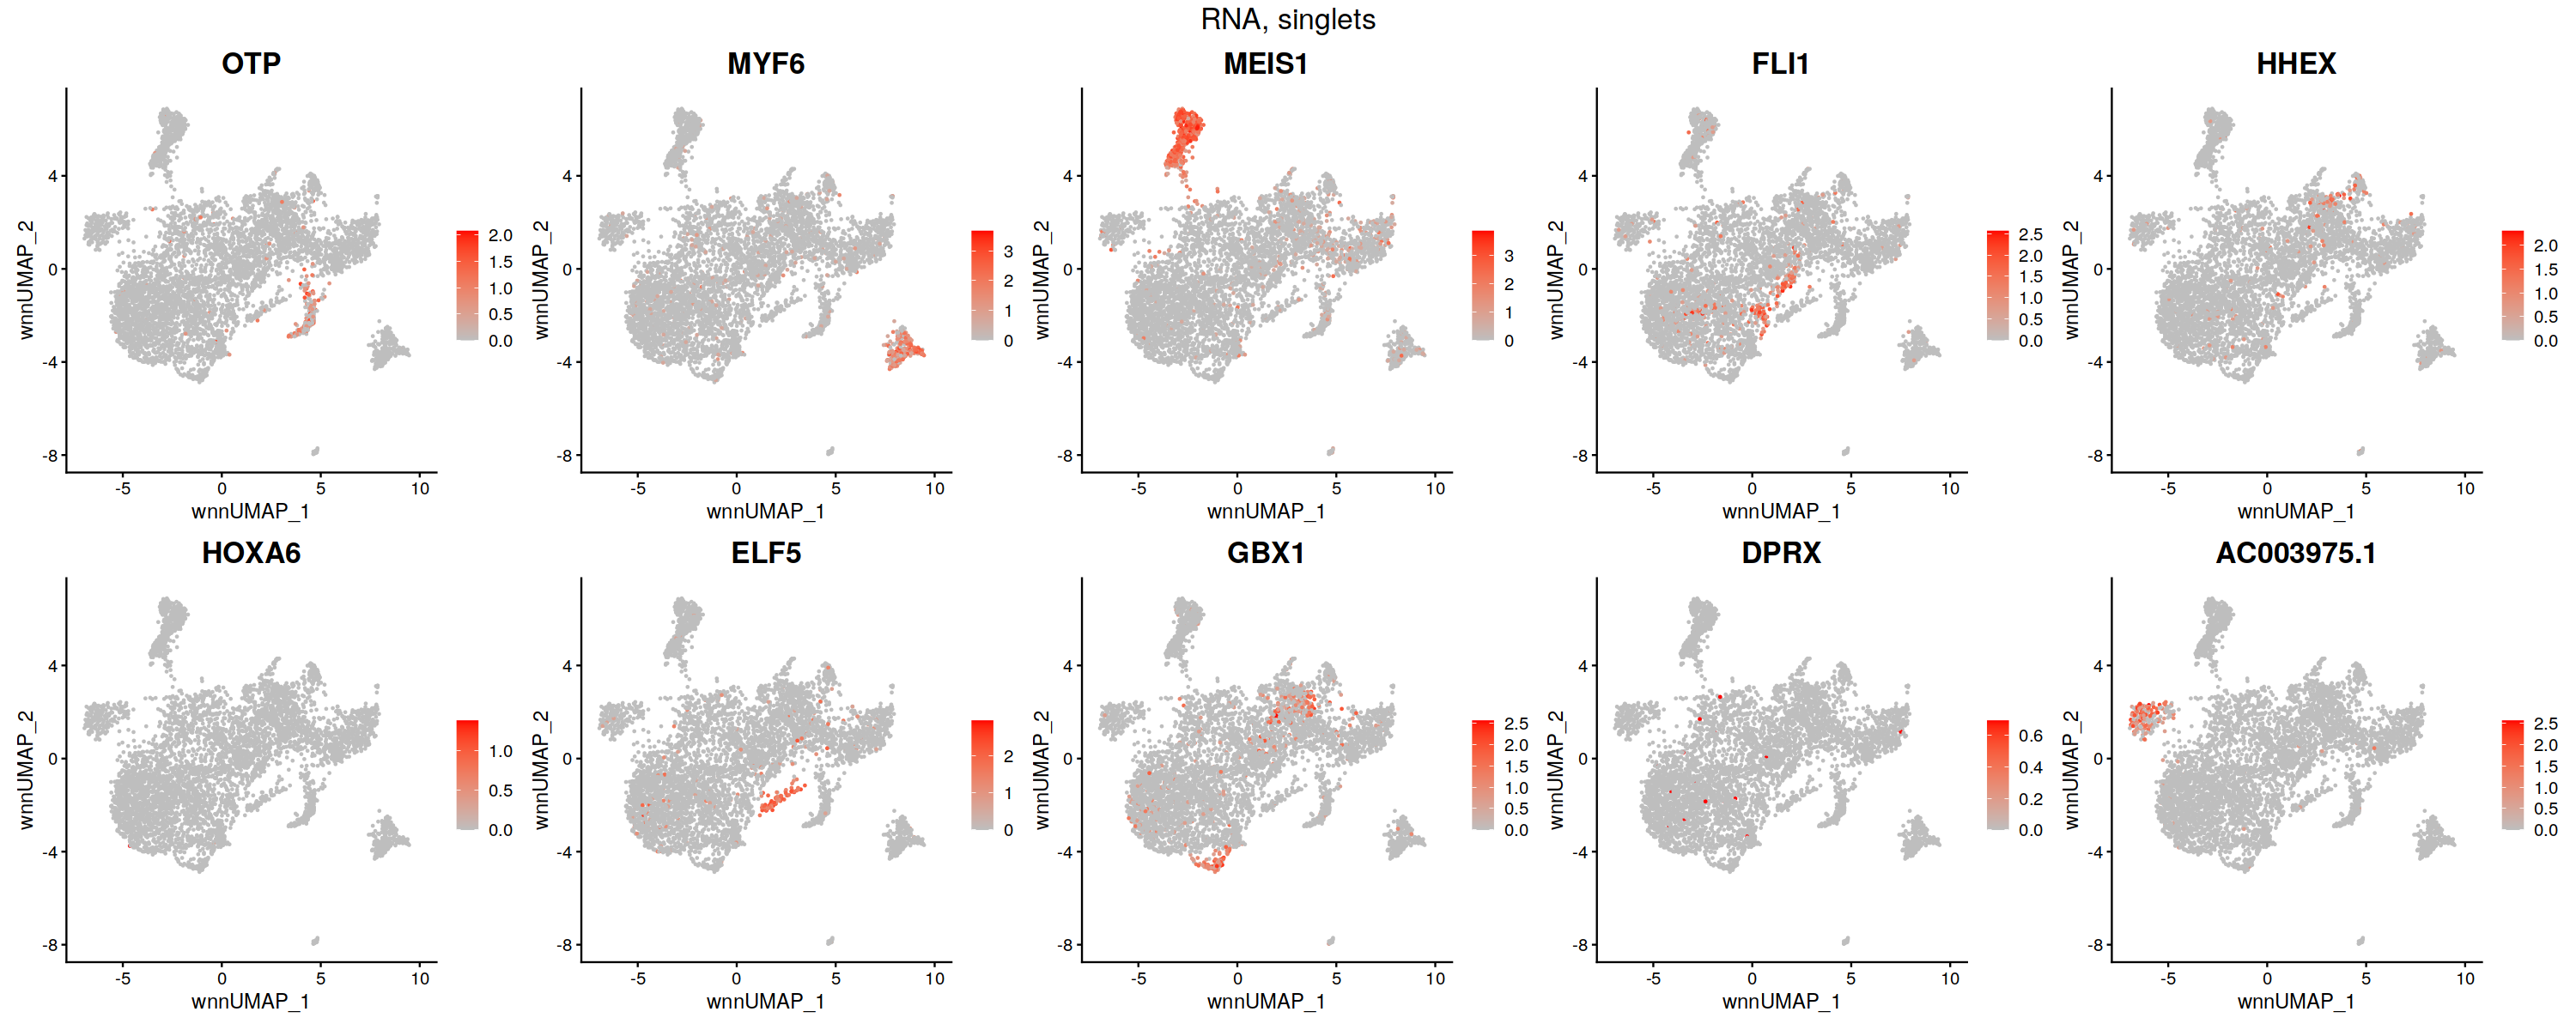

In [12]:
options(repr.plot.width = 25, repr.plot.height = 10)
tf_list <- c(tfs_to_plot, "AC003975.1")
DefaultAssay(seurat) <- "SCT"
FeaturePlot(
    seurat,
    features = tf_list,
    reduction = 'wnn.umap',
    cols = c("grey", "red"),
    keep.scale = "feature",
    ncol = length(tf_list)/2
) +
plot_annotation(title = "RNA, singlets") &
theme(plot.title = element_text(hjust = 0.5, size = 20))


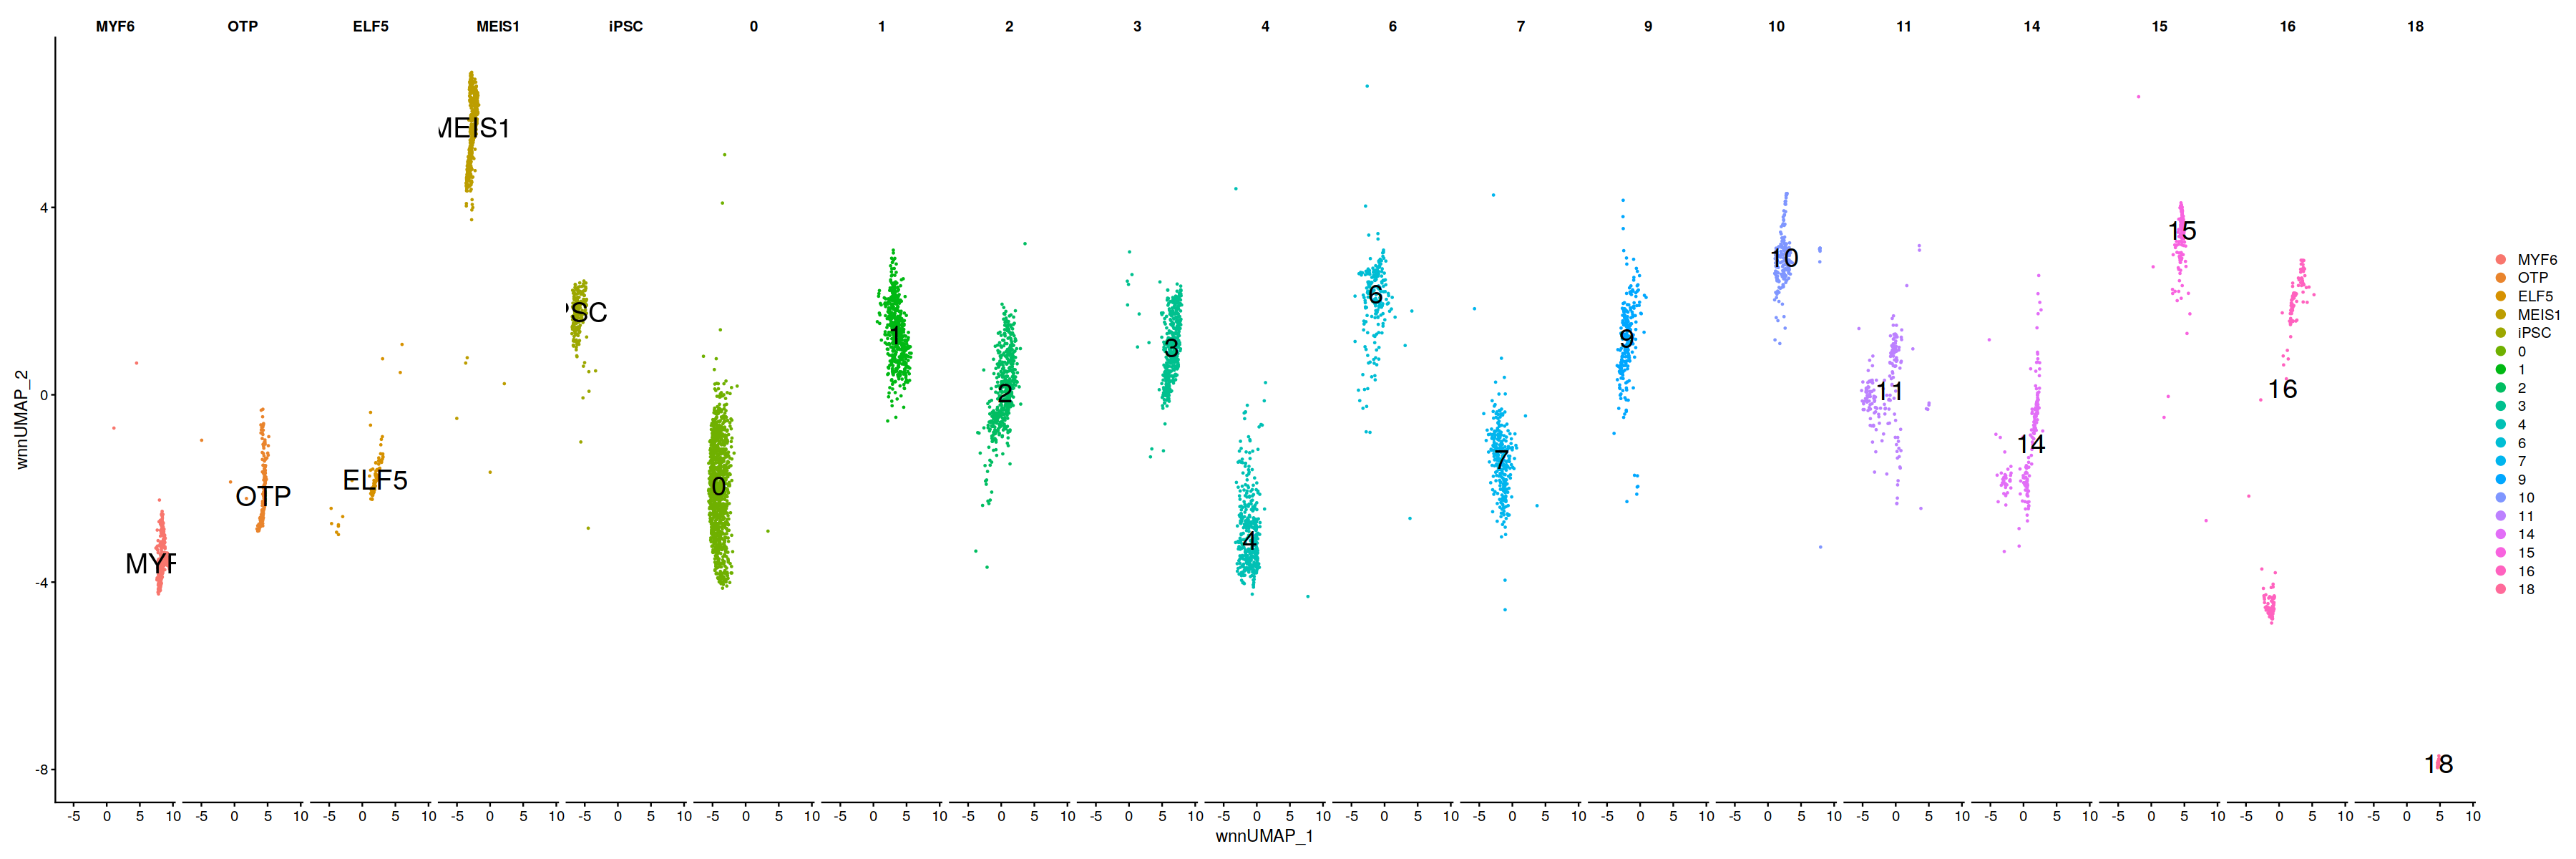

In [13]:
options(repr.plot.width = 30, repr.plot.height = 10)
DimPlot(seurat, reduction = 'wnn.umap', label = TRUE,  label.size = 8, split.by='ident')

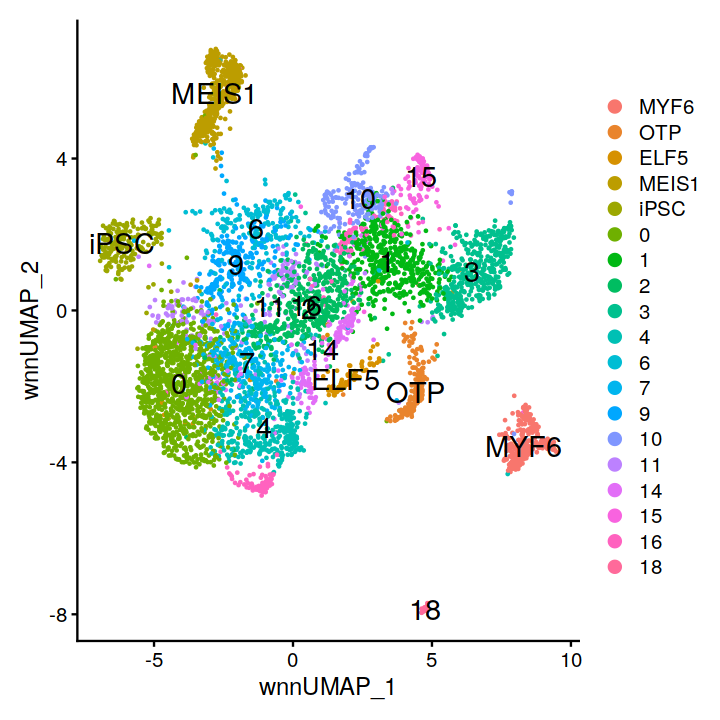

In [14]:
options(repr.plot.width = 6, repr.plot.height = 6)
DimPlot(seurat, reduction = 'wnn.umap', label = TRUE,  label.size = 6)

# Run cell ID

## Setup Panglao DB

In [15]:
# download all cell-type gene signatures from panglaoDB
panglao <- read_tsv("https://panglaodb.se/markers/PanglaoDB_markers_27_Mar_2020.tsv.gz")

Rows: 8286 Columns: 14
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): species, official gene symbol, cell type, nicknames, product descri...
dbl (6): ubiquitousness index, canonical marker, sensitivity_human, sensitiv...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [16]:
#filter to get human specific genes
panglao_all <- panglao %>%  filter(str_detect(species,"Hs"))

# convert dataframes to a list of named vectors which is the format for CelliD input
panglao_all <- panglao_all %>%  
  group_by(`cell type`) %>%  
  summarise(geneset = list(`official gene symbol`))
all_gs <- setNames(panglao_all$geneset, panglao_all$`cell type`)

#remove very short signatures
all_gs <- all_gs[sapply(all_gs, length) >= 10]

## Run MCA

In [17]:
DefaultAssay(seurat) <- "SCT"
seurat <- RunMCA(seurat)

Computing Fuzzy Matrix



4.7 sec elapsed


Computing SVD



30.098 sec elapsed


Computing Coordinates



1.228 sec elapsed


## ID MYF6


calculating distance


ranking genes

146 pathways kept for hypergeometric test out of 151, 5 filtered as less than 10 features was present in the data


calculating features overlap


performing hypergeometric test




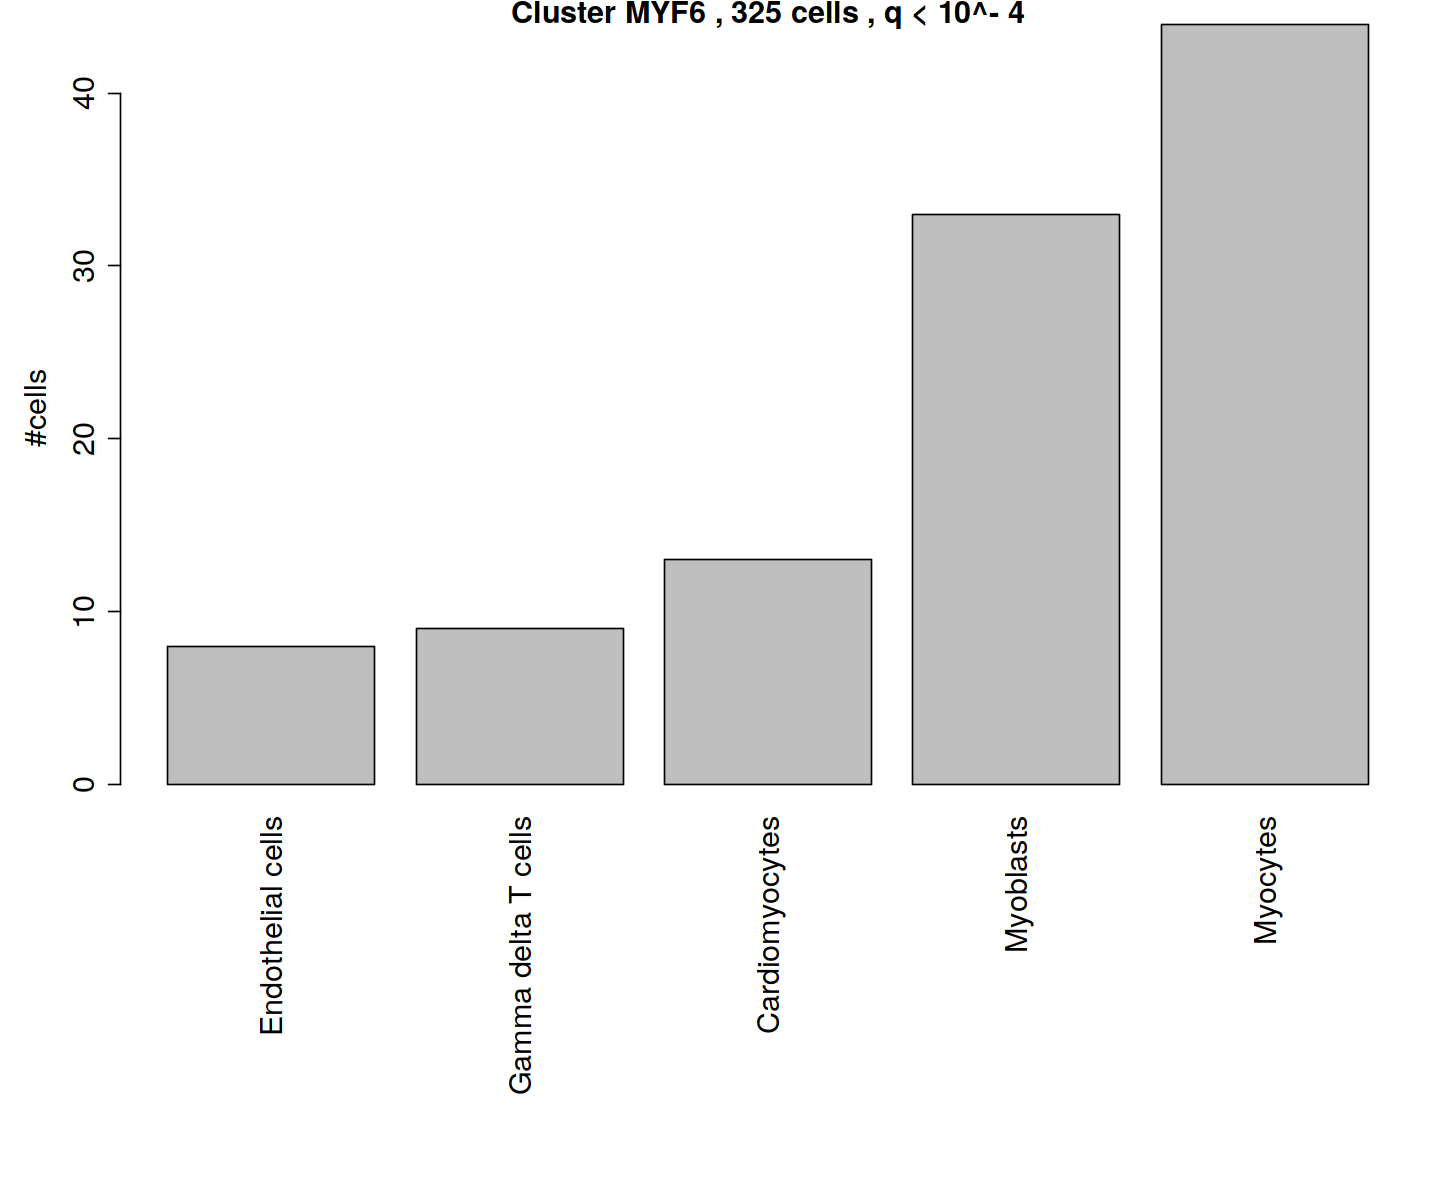

In [18]:
max_q_val  <- 4
#cluster_id <- "ALL_CELLS"
cluster_id <- 'MYF6'
pred_table <- get_cell_ids(seurat, cluster_id, max_q_val, cellid_output_path)

## ID OTP


calculating distance


ranking genes

146 pathways kept for hypergeometric test out of 151, 5 filtered as less than 10 features was present in the data


calculating features overlap


performing hypergeometric test




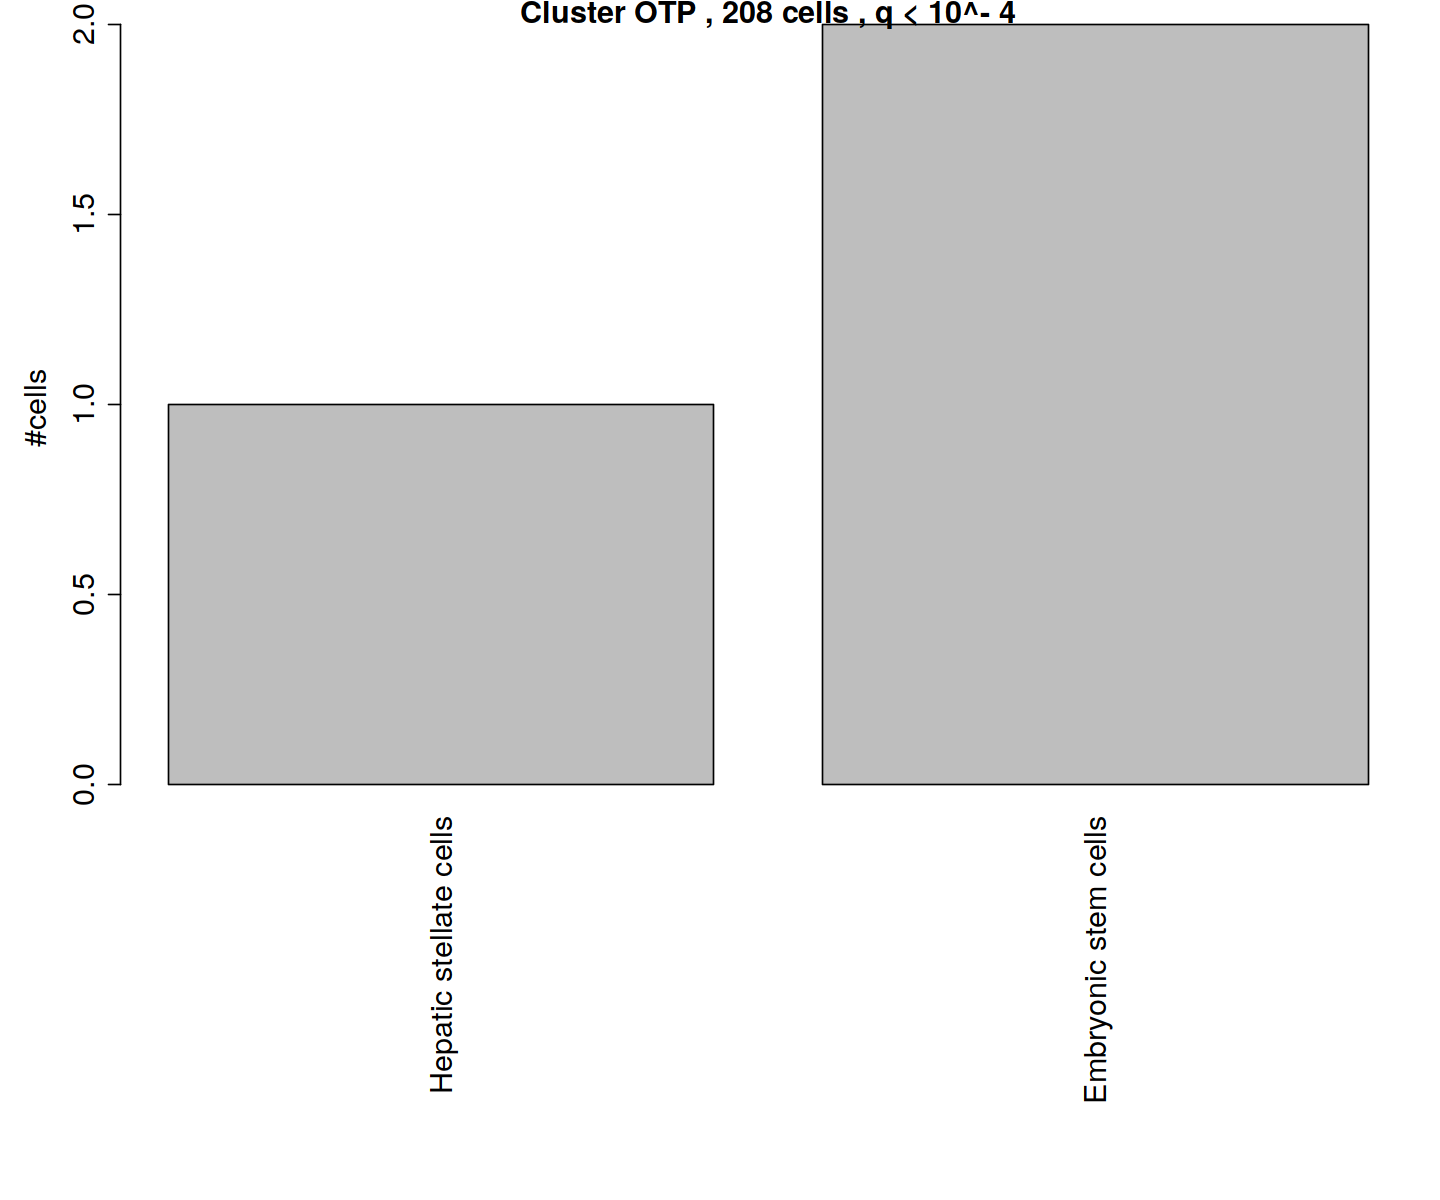

In [19]:
max_q_val  <- 4
cluster_id <- 'OTP'
pred_table <- get_cell_ids(seurat, cluster_id, max_q_val, cellid_output_path)

## ID MEIS1


calculating distance


ranking genes

146 pathways kept for hypergeometric test out of 151, 5 filtered as less than 10 features was present in the data


calculating features overlap


performing hypergeometric test




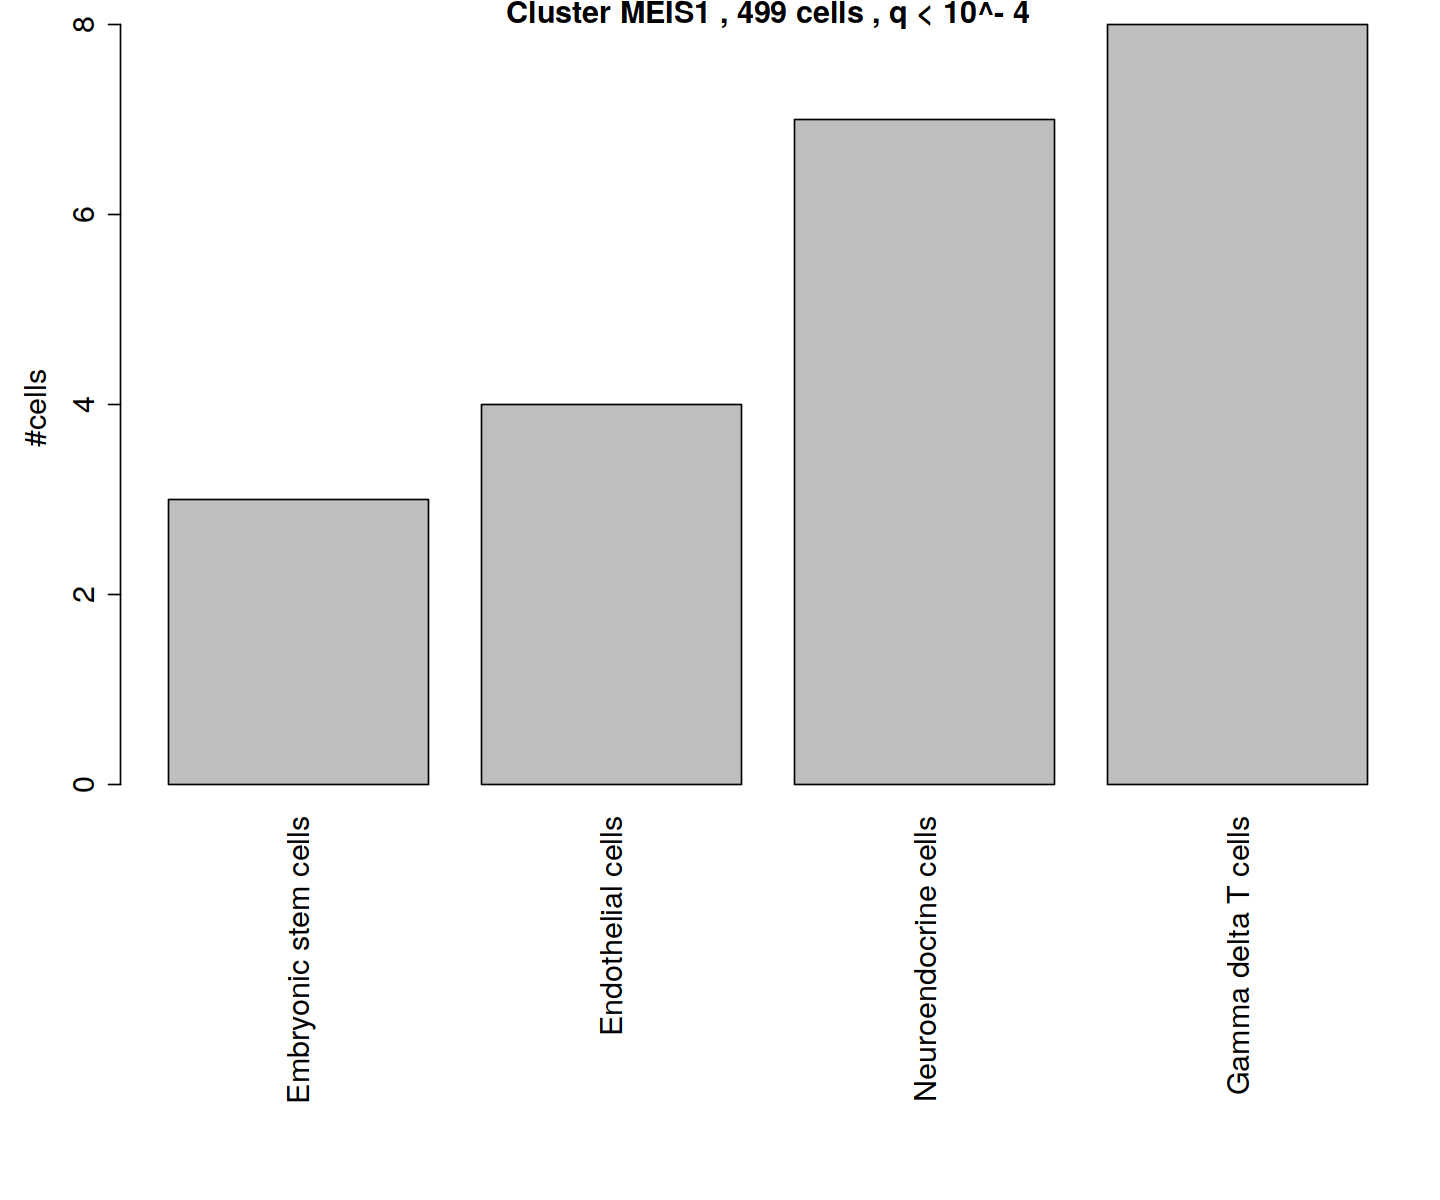

In [20]:
max_q_val  <- 4
cluster_id <- 'MEIS1'
pred_table <- get_cell_ids(seurat, cluster_id, max_q_val, cellid_output_path)

In [21]:
## ID ELF5


calculating distance


ranking genes

146 pathways kept for hypergeometric test out of 151, 5 filtered as less than 10 features was present in the data


calculating features overlap


performing hypergeometric test




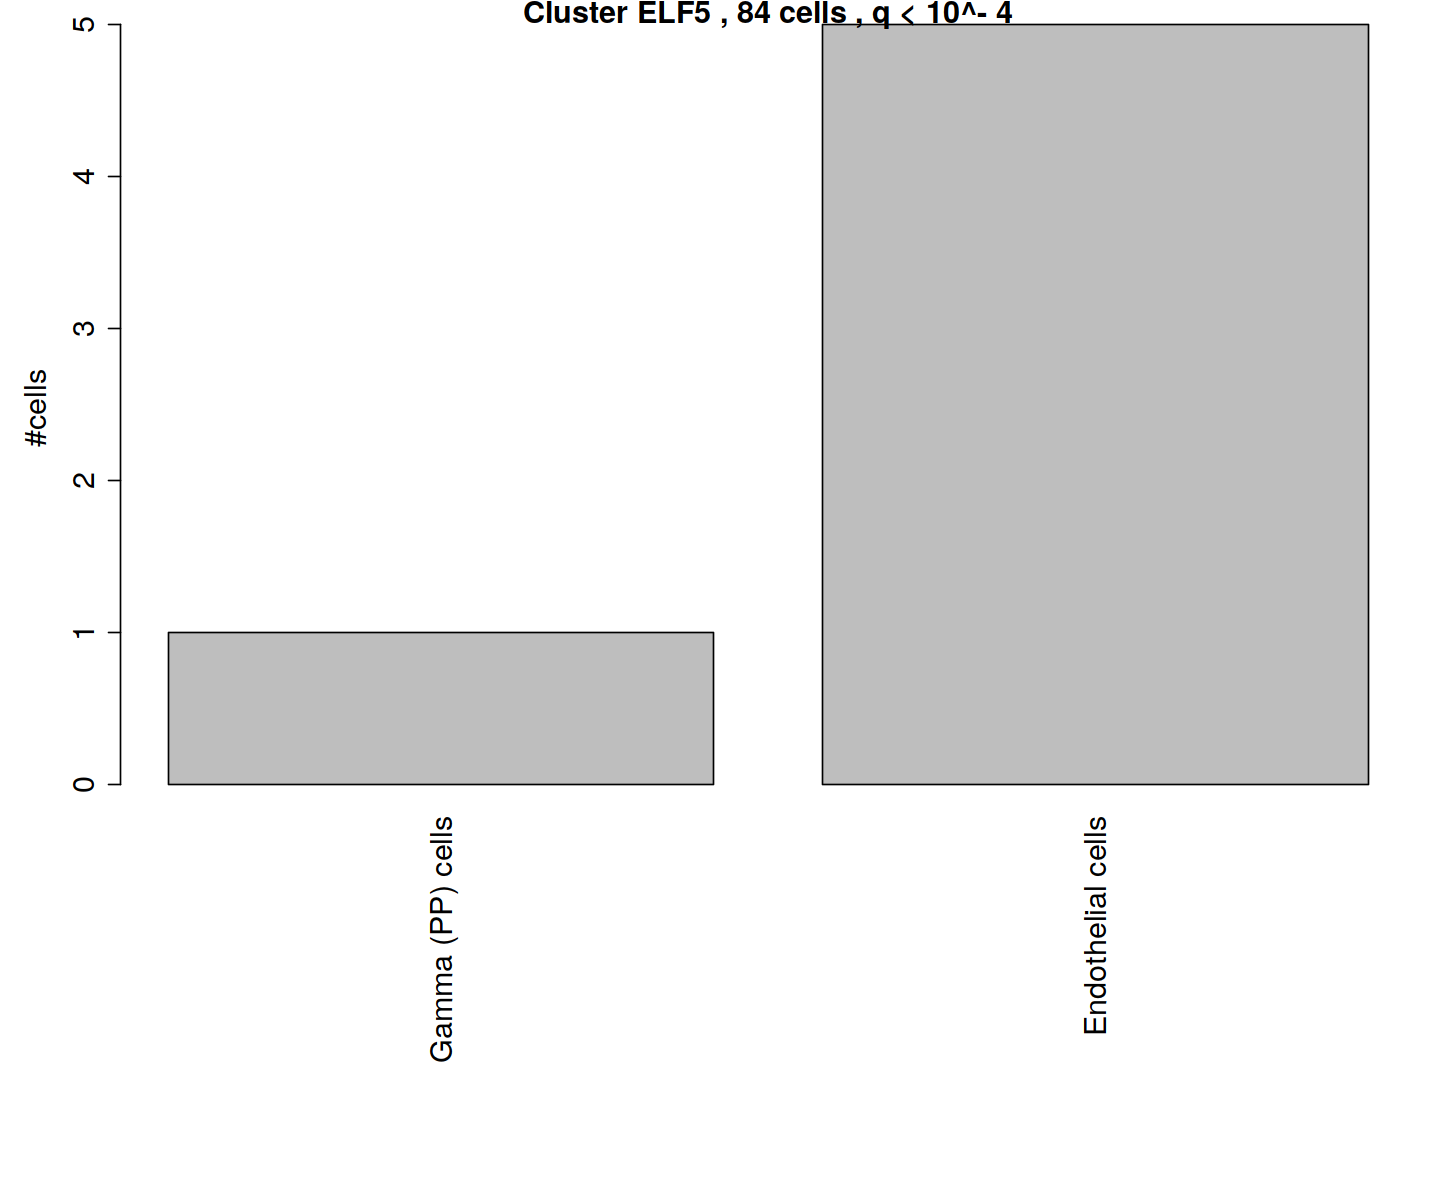

In [22]:
max_q_val  <- 4
cluster_id <- 'ELF5'
pred_table <- get_cell_ids(seurat, cluster_id, max_q_val, cellid_output_path)

## ID ALL


calculating distance


ranking genes

146 pathways kept for hypergeometric test out of 151, 5 filtered as less than 10 features was present in the data


calculating features overlap


performing hypergeometric test




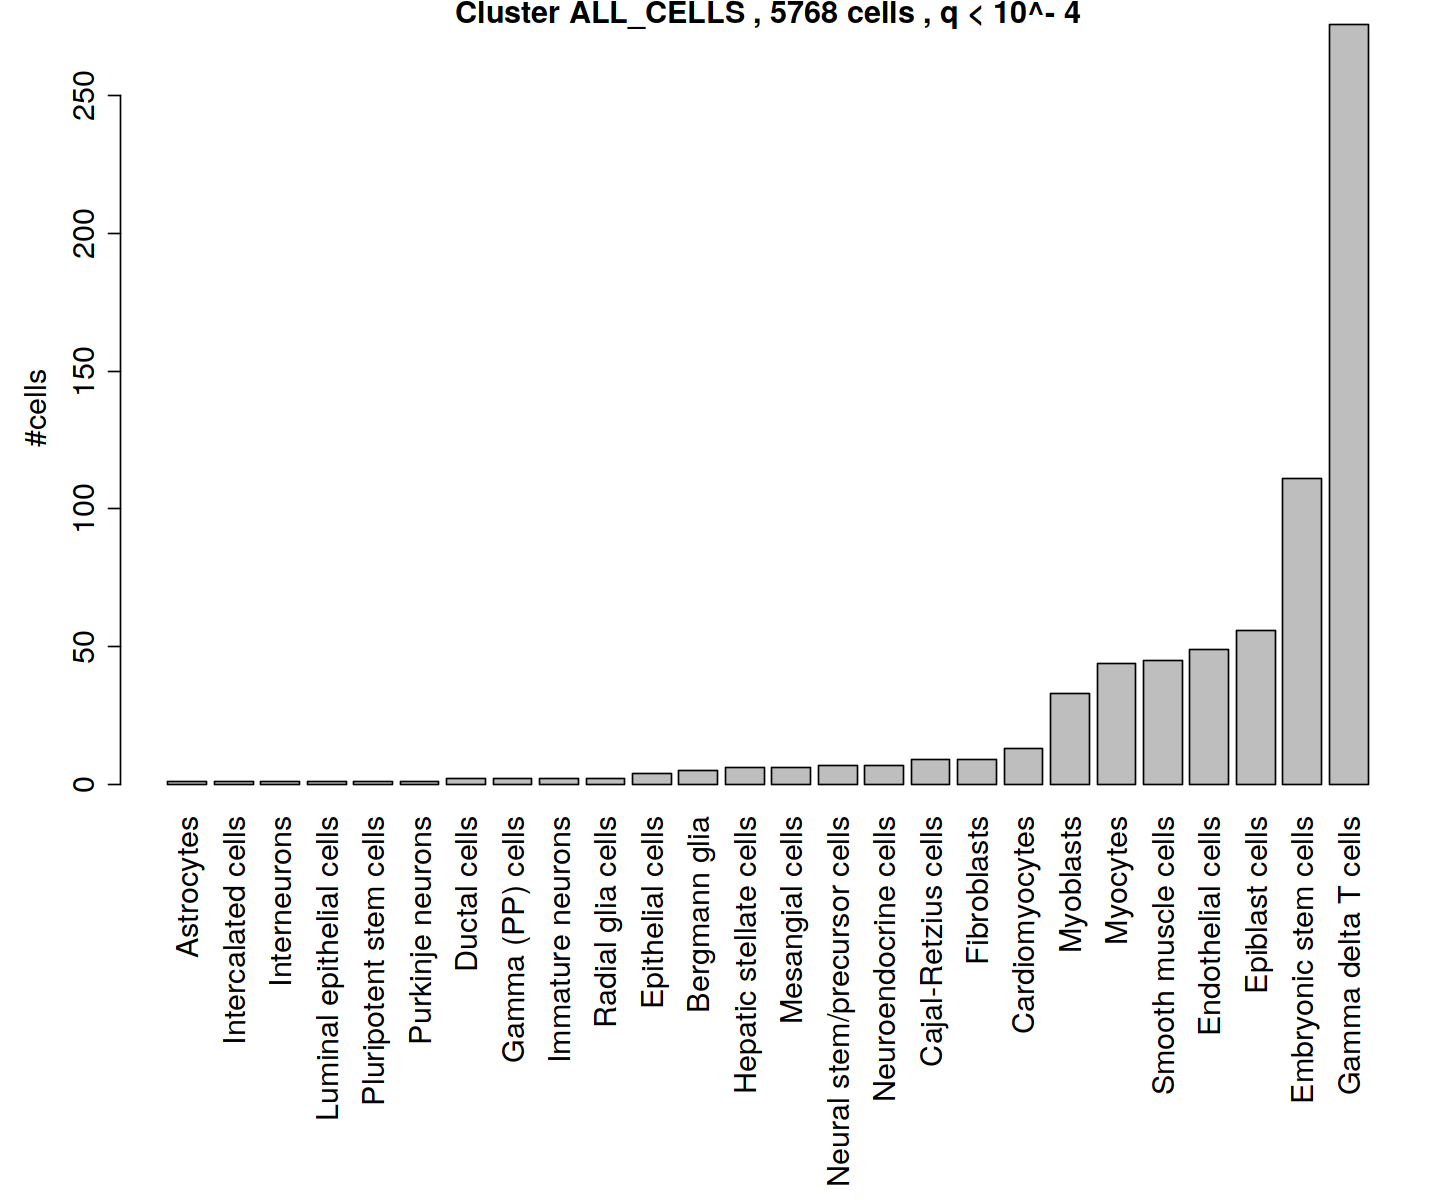

In [23]:
max_q_val  <- 4
cluster_id <- "ALL_CELLS"
pred_table <- get_cell_ids(seurat, cluster_id, max_q_val, cellid_output_path)

In [24]:
subset_seurat <- seurat
HGT_all_gs <- RunCellHGT(subset_seurat, pathways = all_gs, dims = 1:50)

all_gs_prediction <- rownames(HGT_all_gs)[apply(HGT_all_gs, 2, which.max)]


calculating distance


ranking genes

146 pathways kept for hypergeometric test out of 151, 5 filtered as less than 10 features was present in the data


calculating features overlap


performing hypergeometric test




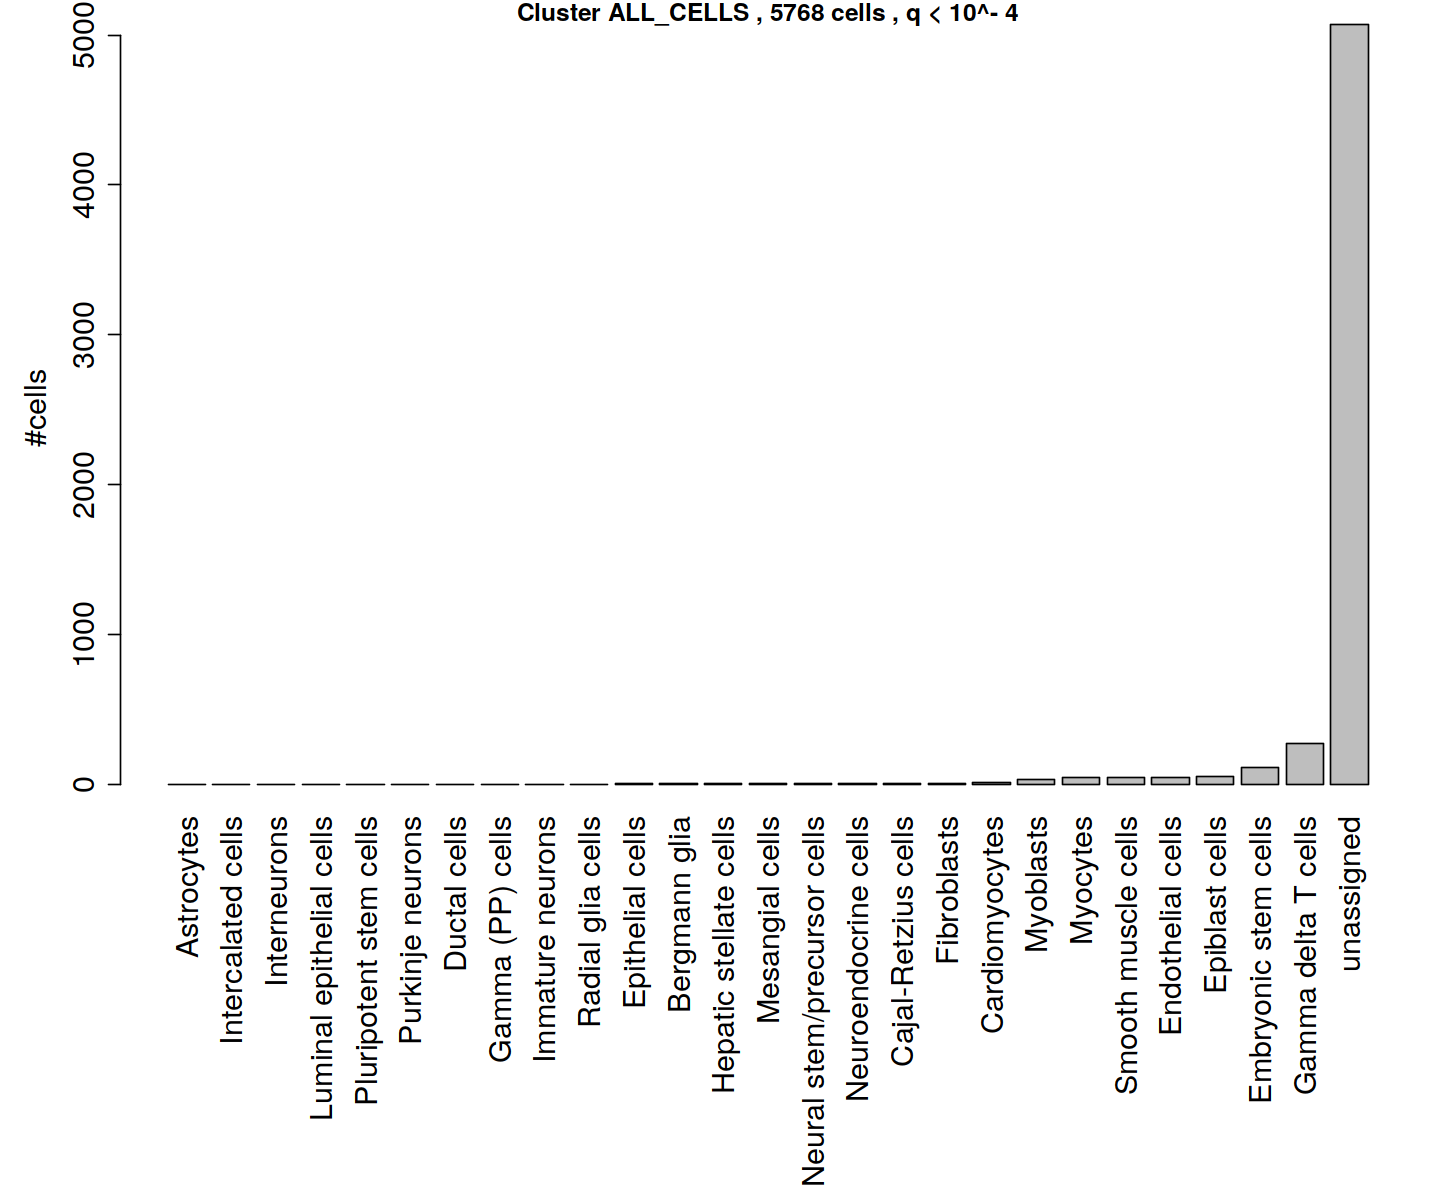

In [25]:
max_minuslog10_q_val = 4
all_gs_prediction_signif <- ifelse(
    apply(HGT_all_gs, 2, max) > max_minuslog10_q_val, 
    yes = all_gs_prediction, 
    "unassigned"
)
cell_count <- length(all_gs_prediction)
plot_title <- paste("Cluster", cluster_id, ",", cell_count, "cells", ", q < 10^-", max_minuslog10_q_val)
file_name  <- paste0("Cluster_", cluster_id, "__q_1e-", max_minuslog10_q_val,".png")
options(repr.plot.width=12, repr.plot.height=10)
par(las=3)
par(mar=c(17,5,1,1))
pred_table <- sort(table(all_gs_prediction_signif))
#pred_table <- t(as.matrix(as.data.frame(pred_table)))
barplot(pred_table, 
        main=plot_title,
        xlab = "",
        ylab = "#cells",
        cex.axis = 1.5,
        cex.lab = 1.5,
        cex.names = 1.5
)



In [26]:
df_pred_table = as.data.frame(pred_table)